# Import

In [1]:
# only use CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [42]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image, display
import numpy as np
import importlib

In [3]:
# models
import models.sdf as SDF
import models.conditional as Conditional

# loss
import models.loss as Loss

# training
import models.training as Training

# data
import models.data as Data

In [4]:
# gpu_lst = tf.config.list_physical_devices("GPU")
# if not gpu_lst:
#     raise Exception("No GPU")

In [37]:
# view pydot
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# Data

In [5]:
path = "../datasets"

In [6]:
ls ../datasets

char/  macro/  RF/


## Macro data

In [7]:
macro_path = f"{path}/macro/macro_train.npz"

In [8]:
macro_data = np.load(macro_path)

In [9]:
macro_data.files

['date', 'variable', 'data']

In [10]:
macro_data["data"].shape

(240, 178)

1. 178 macro features
2. 240 time entries

In [11]:
# each date entry has 178 macro features
macro_data["data"][0].shape

(178,)

## Firm data

In [12]:
firm_path = f"{path}/char/Char_train.npz"

In [13]:
firm_data = np.load(firm_path)

In [14]:
firm_data.files

['date', 'variable', 'data']

In [15]:
firm_data["data"].shape

(240, 3686, 47)

1. 46 firm-specific characteristics
2. 1 excess return - to be used for SDF construction
3. 240 time entry
4. 3686 firms

In [16]:
# each date entry has 3686 firms, 46 firm specific char + 1 return
firm_data["data"][0].shape

(3686, 47)

## Data cleaning

In [17]:
importlib.reload(Data)
macro_train, firm_train, return_train, mask_train = Data.Data().clean(macro_data["data"], firm_data["data"])

Total time period: 240

Total firms: 3686

Total macro, firm features: 178, 46

In [18]:
macro_train.shape, firm_train.shape, return_train.shape, mask_train.shape

((240, 1, 178), (240, 3686, 46), (240, 3686), (240, 3686))

In [19]:
n = 5
sample = [
    macro_train[:, :, :],
    firm_train[:, :n, :],
    return_train[:, :n],
    mask_train[:, :n]
]

In [20]:
# we take 5 samples to test run
for _ in sample:
    print(_.shape)

(240, 1, 178)
(240, 5, 46)
(240, 5)
(240, 5)


# Models

## SDF

In [21]:
importlib.reload(SDF)
sdf = SDF.SDFModel()
sdf(sample).shape

TensorShape([240, 1])

In [22]:
sdf.summary()

Model: "SDF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
State_RNN (LSTM)             multiple                  2928      
_________________________________________________________________
SDF_dense1 (Dense)           multiple                  1632      
_________________________________________________________________
SDF_dense2 (Dense)           multiple                  1056      
_________________________________________________________________
SDF_w (Dense)                multiple                  33        
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 5,649
Trainable params: 5,649
Non-trainable params: 0
_________________________________________________________________


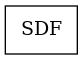

In [43]:
view_pydot(model_to_dot(sdf))

In [23]:
importlib.reload(Conditional)
conditional = Conditional.ConditionalModel()
conditional(sample).shape

TensorShape([8, 240, 5])

In [24]:
conditional.summary()

Model: "Condtional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Moment_RNN (LSTM)            multiple                  27008     
_________________________________________________________________
Conditional_g (Dense)        multiple                  632       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 27,640
Trainable params: 27,640
Non-trainable params: 0
_________________________________________________________________


# Loss

In [27]:
importlib.reload(Loss)
pricing_loss = Loss.PricingLoss()
pricing_loss(
    sdf = sdf(sample),
    moment = conditional(sample),
    return_data = sample[2],
    mask = sample[3],
    verbose = True
)

mask shape = (240, 5)
return data shape = (240, 5)
SDF shape: (240, 1)
moment shape: (8, 240, 5)
masked return shape: (240, 5)
empirical mean shape: (8, 5)
empirical mean shape: (8, 5)
loss shape: (8, 5)
normalized loss shape: ()
tf.Tensor(8.050762e-06, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=8.050762e-06>

In [28]:
pricing_loss.sharpe_loss(
    sdf = sdf(sample)
)

-0.058704566

# Training

Macro feature: 240 x 178
Firm feature: 240 x ? x 46
Return: 240 x ?
Mask: 240 x ?

In [31]:
importlib.reload(Training)
trainer = Training.Trainer(loss=Loss.PricingLoss())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [36]:
trainer.train(
    sdf_model=sdf,
    conditional_model=conditional,
    optimizer=optimizer,
    inputs=sample,
    valid_inputs=sample,
    sdf_epoches_unc=1,
    moment_epoches=1,
    epoches=1,
    verbose_freq=100
)

==============Start unconditional training===========

                      unconditional SDF epochs 0
                      epoch loss = 7.385207572951913e-05
                      epoch Sharpe = (-0.03154529, -0.059385043)
                      max Sharpe = (0, 0)
                      
==============Start moments training===========

                      moments epochs 0
                      epoch loss = -8.135479220072739e-06
                      
==============Start GAN training===========

                      epochs 0
                      epoch SDF loss = 6.281208334257826e-05
                      epoch moment loss = -1.4170555914461147e-05
                      epoch Sharpe = (-0.059304785, -0.059785888)
                      max Sharpe = (0, 0)
                      
